In [3]:
from astropy.io import fits
import numpy as np
import scipy.integrate as integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def BlackBody(nu_t):
    if nu_t>15:
        spec=np.float128(nu_t**3*(np.exp(np.float128(-nu_t))))
    else:
        spec=np.float128(nu_t**3/(np.exp(np.float128(nu_t))-1))
    return spec;
    
def dBlackBodydT(nu_t):
    if nu_t < 0.001:
        dbdt = nu_t**2-nu_t**4/12.0
    elif nu_t > 15:
        dbdt = nu_t**4*np.exp(-nu_t)
    else:
        dbdt=nu_t**4 *np.exp(nu_t)/(np.exp(nu_t)-1)**2   
    
    return dbdt;

def planck_mean(nu_t,hud):
    kappa=get_kap(nu_t,hud)
    return kappa*BlackBody(nu_t)
    
def rossmean(nu_t,hud):
    return dBlackBodydT(nu_t)/(hud[3].data['scattering'][0]/(1.67e-24*hud[1].data['value'][names=='density'])+get_kap(nu_t,hud))


In [3]:
def get_kap(nu_t,hud):
    '''interpolates over energy to find the opacity'''
    nu_t=nu_t*T*e0
    
    if nu_t>max(hud[3].data['energy']):
        return hud[3].data['opacity '][-1]
    
    return np.interp(nu_t,hud[3].data['energy'],hud[3].data['opacity'])/(1.67e-24*hud[1].data['value'][names=='density'])
    

In [7]:
kB=8.6173e-5 #ev
T0=2e5 #K
e0=kB*T0 #in ev which is what xstar results are in

In [9]:
#temperature and density grids I used in XSTAR
Tgrid=np.logspace(np.log10(5e3),np.log10(1e6),100)
rhogrid=np.logspace(-15,-7,20)/1.67e-24

#create empty arrays for the opacities
kappa_p_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))
kappa_a_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))


for nT in range(np.size(Tgrid)):
    for nrho in range(np.size(rhogrid)):
        num=str(nT*len(rhogrid)+nrho)

        hud = fits.open('/Users/asecunda/Documents/thesis/radsims1/toyanfeiv2 (1)/work//ares/opakout'+str(num)+'.fits')
        energy=hud[3].data['energy']/e0

        T=Tgrid[nT]/T0
        rho=rhogrid[nrho]

        resulta=0
        weighta=0
        resultp=0
        weightp=0
        
        names=hud[1].data['parameter']

        for nen in range(445,len(energy)):
            de=(energy[nen-1]-energy[nen])/T
            resulta+=(rossmean(energy[nen]/T,hud)+rossmean(energy[nen-1]/T,hud))*de/2
            weighta+=(dBlackBodydT(energy[nen]/T)+dBlackBodydT(energy[nen-1]/T))*de/2

            resultp+=(planck_mean(energy[nen]/T,hud)+planck_mean(energy[nen-1]/T,hud))*de/2
            weightp+=(BlackBody(energy[nen]/T)+BlackBody(energy[nen-1]/T))*de/2

        kappa_a_fr[nT,nrho]=weighta/resulta

        kappa_p_fr[nT,nrho]=resultp/weightp

Text(0, 0.5, '$\\kappa_{\\rm r}$ [cm$^2~$g$^{-1}$]')

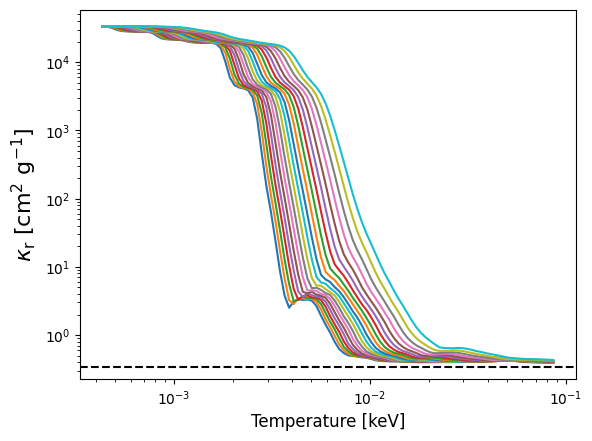

In [12]:
fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_a_fr)
#plt.xlim(1e-4,0.1)
#plt.ylim(0.01,5)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(0.34,color='black',linestyle='dashed')
plt.xlabel('Temperature [keV]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm r}$ [cm$^2~$g$^{-1}$]',fontsize=16)

plt.tight_layout()

Text(0, 0.5, '$\\kappa_{\\rm p}$ [cm$^2~$g$^{-1}$]')

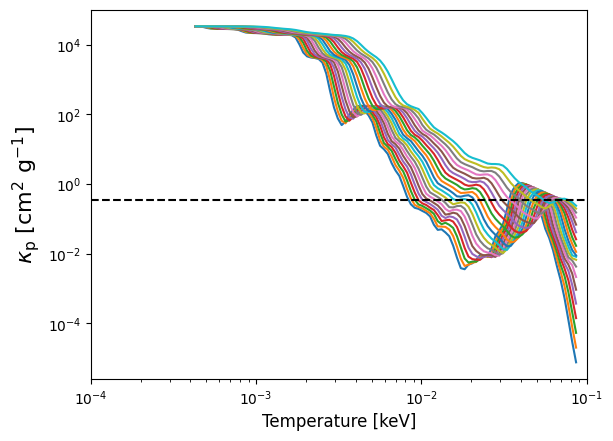

In [13]:
fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_p_fr)
#plt.xlim(1e-4,0.1)
#plt.ylim(0.001,1e6)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(0.34,color='black',linestyle='dashed')
plt.xlabel('Temperature [keV]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm p}$ [cm$^2~$g$^{-1}$]',fontsize=16)

plt.tight_layout()